# Reactors with Recycle

During L26, we considered the idea that a reactor-with-recycle process could be used to attain high overall (process-level) conversion for reactions that are somehow limited to low single pass (once through the reactor) conversion.  The scenario we considered in class was an equilibrium-limited reaction (propane dehydrogenation), but reactor-with-recycle schemes can also be used to improve overall yields when dealing with sequential reactions.  Specifically, it allows one to operate the reactor at relatively low single-pass conversion to avoid secondary reactions, but it recycles the remainder to allow a high overall conversion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

## Problem 01: A Recap of the Propane Dehydrogenation Example

<img src="PFRRecycle.jpg" width="700" height="500" />

We will  operate the PFR at 8.2 atm and 500K, and we are feeding propane into the *process* at 10 moles per minute.  Under these conditions, we know that:

\begin{align*}
    k_f  &= 0.7  \ \textrm{min}^{-1} \\
    K_C &= 0.05 \ \textrm{mol} \ \textrm{L}^{-1}\\	
\end{align*}	

1. Determine the minimum recycle ratio required to achieve an overall propylene yield of 95% during propane dehydrogenation.
2. For this recycle ratio, determine the size of PFR required to achieve an overall propylene yield of 95%.

### Solution to the in class example

#### Analysis of the overall process

If we draw a black box around the whole process, we know that it must achieve 95% conversion of the propane fed into the process at a flowrate of 10 mol/min.  We can therefore define the exit flowrate of propane in terms of the inlet flowrate and the overall conversion

$$F_{A4} = F_{A0}\left(1 - X_{A_{ov}}\right)$$

#### Analysis of the Splitter

A balance on the splitter gives:

$$0 = F_{A3} - F_{A4} - F_{A5}$$

We can express the recycle flowrate as a fraction of the flow into the splitter, i.e., 

$$F_{A5} = \alpha F_{A3}$$

Substituting this into the splitter balance, we find:

$$0 = F_{A3} - F_{A4} - \alpha F_{A3}$$

We can solve for $F_{A3}$ to find:

$$F_{A3} = \frac{1}{1 - \alpha}F_{A4}$$

And we can substitute this back into the definition for $F_{A5}$:

$$F_{A5} = \frac{\alpha}{1 - \alpha} F_{A4}$$

#### Analysis of the separator

A balance on the separator is straightforward and tells us that:

$$F_{A2} = F_{A3}$$

#### Analysis of the mixer

A balance on the mixer will give us the combined feed rate into the reactor, $F_{A0}$

$$F_{A1} = F_{A0} + F_{A5}$$

#### Analysis of the reactor 

If we look at the reactor, we can define a single pass fractional conversion in terms of $F_{A1}$ and $F_{A2}$:

$$X_{SP} = \frac{F_{A1} - F_{A2}}{F_{A1}}$$

We still have a degree of freedom in this system, so we can't solve it just yet.  But, once we specify the recycle ratio, we can fully solve for all flowrates and the single pass conversion through the PFR. The way I'm approaching the analysis here is that we know the equilibrium limit on this PFR at 500K and 8.2 atm is ~ 44% conversion, so we just have to find a recycle ratio that will allow us to operate with a PFR below 44% conversion.

In [2]:
α   = 0.0
XOV = 0.95
FA0 = 10 #mol/min
FA4 = FA0*(1 - XOV)
FA3 = FA4/(1 - α)
FA2 = FA3
FA5 = α*FA3
FA1 = FA0 + FA5
XSP = (FA1 - FA2)/FA1

labels = ['α', 'FA0', 'FA1', 'FA2', 'FA3', 'FA4', 'FA5', 'XSP', 'XOV']
values = [α, FA0, FA1, FA2, FA3, FA4, FA5, XSP, XOV]

for label, value in zip(labels, values):
    if label == 'XSP' or label == 'XOV' or label == 'α':
        print(f'{label:3s} = {value:5.2f}')
    else:
        print(f'{label:3s} = {value:5.2f} mol/min')

α   =  0.00
FA0 = 10.00 mol/min
FA1 = 10.00 mol/min
FA2 =  0.50 mol/min
FA3 =  0.50 mol/min
FA4 =  0.50 mol/min
FA5 =  0.00 mol/min
XSP =  0.95
XOV =  0.95


#### Solve the PFR Balance

Now that we know the recycle ratio (and therefore the feed into the reactor, $F_{A0}$), we can solve the material balance to determine the PFR size required to achieve a single pass conversion of 0.4318

In [3]:
kf = 0.7  #1/min
KC = 0.05 #mol/L
kr = kf/KC #L/mol/min
T  = 500 #K
P  = 8.2 #atm
R  = 0.08206 #L*atm/mol/K

In [4]:
def P01(V, var, par):
    FA, FB, FC = var
    kf, kr, T, P, R = par
    
    FT = FA + FB + FC
    
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    CC = FC/Q
    
    r  = kf*CA - kr*CB*CC
    
    RA = -r
    RB =  r
    RC =  r
    
    dA = RA
    dB = RB
    dC = RC
    
    return [dA, dB, dC]

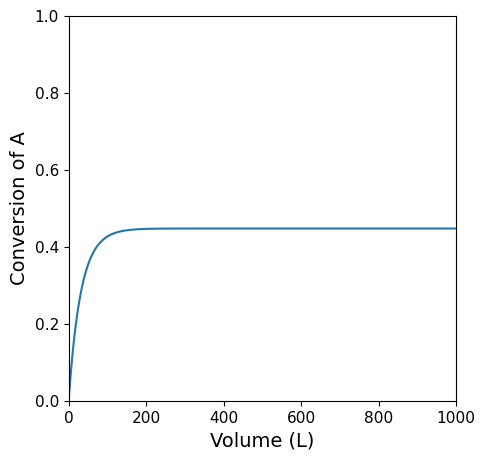

ValueError: A value (0.95) in x_new is above the interpolation range's maximum value (0.4473444481820728).

In [5]:
FAf = FA1 #mol/min
FBf = 0.0
FCf = 0.0
Vspan = (0.0, 1000.0)
var0  = (FAf, FBf, FCf)
par0  = (kf, kr, T, P, R)
ans2  = solve_ivp(P01, Vspan, var0, args = (par0, ), atol = 1e-8, rtol =  1e-8)

V     = ans2.t
FA    = ans2.y[0, :]
FB    = ans2.y[1, :]
FC    = ans2.y[2, :]

XA    = (FAf - FA)/FAf

plt.figure(1, figsize = (5, 5))
plt.plot(V, XA)
plt.xlim(0.0, max(Vspan))
plt.xticks(fontsize = 11)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylim(0.0, 1.0)
plt.yticks(fontsize = 11)
plt.ylabel('Conversion of A', fontsize = 14)
plt.show(1)

itp1 = interp1d(XA, V)
print(f'The Volume required for a PFR single pass conversion of XA = {XSP:0.4f} is {itp1(XSP):0.0f}L')

### This was an easy problem...

The above example is probably the simplest possible scenario that we can consider in that we are given the overall process level conversion (0.95) and allowed to vary the recycle ratio until we find the point where the single pass reactor level conversion is within the equilibrium limit.

This case is straightforward for the following reasons:

1. Because we have a specification on the overall conversion of the process (95%), it is straightforward to calculate $F_{A4}$:

\begin{align}
    F_{A4} = F_{A0}(1 - X_{A_{ov}})\\
    F_{A4} = 0.5 \ \textrm{mol} \ \textrm{min}^{-1}
\end{align}
    
2. Since we were given the freedom to adjust the recycle ratio to reduce the necessary single pass conversion, we can set the recycle ratio to a value--here we found that $\alpha = 0.96$ will permit the PFR to operate at a conversion that is less than the equilibrium limit.  Once $\alpha$ is specified, the balance on the splitter gives:

\begin{align}
    F_{A3} &= \frac{1}{1 - \alpha} F_{A4} \\
    F_{A5} &= \frac{\alpha}{1 - \alpha} F_{A4} \\
\end{align}

Since $F_{A4}$ and $\alpha$ are known here, we can solve to get:

\begin{align}
    F_{A3} = 12.5 \ \textrm{mol} \ \textrm{min}^{-1}\\
    F_{A5} = 12.0 \ \textrm{mol} \ \textrm{min}^{-1}\\
\end{align}

3. A balance on the separator then tells us that:

$$F_{A2} = F_{A3} = 12.5 \ \textrm{mol} \ \textrm{min}^{-1}$$


4. A balance on the mixer gives us:

$$F_{A1} = F_{A0} + F_{A5} = 22.0 \ \textrm{mol} \ \textrm{min}^{-1}$$

5. Since we know the flowrate of propane coming into and out of the reactor, we can calculate the single pass conversion in the reactor:

$$X_{A_{sp}} = 0.432$$

So, basically, with those specifications, we can easily figure out the molar flowrate of A at every point in the PFD, and we can easily size a PFR that operates at 8.2 atm and 500K with an inlet propane flowrate of 22 moles per minute to accomplish 43.2% conversion.

Today, we'll look at problems that are conceptually no more difficult, but are actually much more challenging to solve in practice.

## Problem 02

We will use the same, very simple, very perfect recycle scheme illustrated above for this problem, but for now, we'll replace the PFR with a CSTR. 

<img src="CSTR Recycle.jpg" width="700" height="500" />

In order to facilitate a relatively straightforward solution, we going to run a much simpler reaction--the irreversible conversion of A into B:

$$A \longrightarrow B$$

This reaction occurs in the gas phase, it has a rate constant $k = 10 \ \textrm{s}^{-1}$ and we run it without a diluent, i.e., we feed Pure species A into the process at a rate of 100 moles per second.  The entire process is carried out at T = 573K and P = 1.0 atm.  If the volume of the CSTR is 400L, and we recycle 50% of the unreacted species A, calculate the single pass and overall conversion of A achieved in this process.

The challenge here is that we cannot easily calculate the flowrates of A coming out of the splitter, so we end up needing to solve a large system of equations simultaneously...

### Solution to Example Problem 02

The balances on all of our unit operations are the same; we can write four of them, one on each unit:

#### Balance on Mixer

$$ 0 = F_{A0} + F_{A5} - F_{A1} $$

#### Balance on CSTR
$$ 0 = F_{A1} - F_{A2} + R_{A2}V $$

#### Balance on Separator

$$ 0 = F_{A2} - F_{A3} $$

#### Balance on Splitter

$$ 0 = F_{A3} - F_{A4} - F_{A5} $$

As far as I can tell, we have the following information available to us:

\begin{align}
    k &= 10 \ \mathrm{s^{-1}} \\
    T &= 573 \ \mathrm{K} \\
    P &= 1.0 \ \mathrm{atm} \\
    V &= 400 \ \mathrm{L} \\
    F_{A0} &= 100 \ \mathrm{mol \ s^{-1}} 
\end{align}

Looking at the above set of equations, we have 5 unknown flowrates ($F_{A1}$, $F_{A2}$, $F_{A3}$, $F_{A4}$, $F_{A5}$) and one unknown production rate ($R_{A2}$).  I can specify the production rate in terms of molar flowrates and volumetric flowrates:  

\begin{align}
    R_{A2} &= -r_2 \\
    r_2 &= kC_{A2} \\
    C_{A2} &= \frac{F_{A2}}{Q_2}
\end{align}

We can simplify the problem a bit by realizing that there is no change in the number of moles for this reaction, so the volumetric flowrate entering the CSTR ($Q_1$) is the same as the volumetric flowrate exiting the reactor ($Q_2$). The only species entering the CSTR is A, so we can then calculate the volumetric flowrate entirely based on the flowrate of species A into the reactor, $F_{A1}$:

$$Q_1 = \frac{F_{A1} RT}{P}$$

k, R, T, and P are all known to us, so now we've defined the production rate in terms of molar flowrates.  This leaves us with 5 total unknowns in the problem, so we need one more equation.  We can get it from the specification that the recycle ratio at the splitter is 0.5:

The recycle ratio is defined as:

$$\alpha = \frac{F_{A5}}{F_{A3}}$$

An easy way to add that constraint to the problem is to reformulate it as an algebraic equation whose left hand size is zero:

$$ 0 = F_{A5} - F_{A3}\alpha$$

So now we have 5 equations and 5 unknowns; we can solve this with `opt.root()`

In [7]:
FA0 = 100     #moles per second
k   = 10      #1/sec
T   = 573     #K
P   = 1.0     #atm
R   = 0.08206 #L*atm/mol/K
V   = 400     #L
α   = 0.5

In [8]:
def P02(var, par):
    FA1, FA2, FA3, FA4, FA5 = var
    FA0, k, T, P, R, V, α = par
        
    Q1  = FA1*R*T/P #volumetric flowrate into CSTR
    Q2  = Q1        #A --> B so Q1 = Q2
    CA2 = FA2/Q2    #Concentration of A in CSTR
    r   = k*CA2;    #rate of reaction in CSTR
    RA2 = -r        #Production rate of A in CSTR
    
    LHS1 = FA0 + FA5 - FA1
    LHS2 = FA1 - FA2 + RA2*V
    LHS3 = FA2 - FA3
    LHS4 = FA3 - FA5 - FA4
    LHS5 = FA5 - α*FA3
    return [LHS1, LHS2, LHS3, LHS4, LHS5]

var_guess = (150, 50, 50, 50, 50)
par0 = (FA0, k, T, P, R, V, α)
ans2 = opt.root(P02, var_guess, args = (par0, ))
FA1, FA2, FA3, FA4, FA5 = ans2.x

XSP    = (FA1 - FA2)/FA1
XOV    = (FA0  - FA4)/FA0
alpha  = FA5/FA3
print(f'XSP = {XSP:0.3f}, XOV = {XOV:0.3f}, and α = {α:0.2f}')

XSP = 0.368, XOV = 0.538, and α = 0.50


## Problem 03

Now let's swap the CSTR out for a Plug Flow reactor and work through how that changes the problem.

<img src="PFRRecycle.jpg" width="700" height="500" />

We'll continue with the simple reaction above:

$$A \longrightarrow B$$

This problem has identicial specifications to Problem 1 otherwise. The reaction has a rate constant $k = 10 \ \textrm{s}^{-1}$, and we run it without a diluent. For this process, we are feeding species A in at a rate of 100 moles per second.  The entire process is carried out at T = 573K and P = 1.0 atm. If the volume of the PFR is 400L, and we recycle 50% of the unreacted species A, calculate the single pass and overall conversion of A achieved in this process.

The approach is very similar to the one above in that we have a system of equations.  The additional twist from working with a PFR is that we now have to solve a differential equation in one of our unit balances...

### Solution to Example Problem 03

We start in exactly the same way, by writing balances on each unit operation; this gives us a set of algebraic equations and one problematic ODE that we have to solve to model the PFR behavior.

#### Balance on Mixer

$$ 0 = F_{A0} + F_{A5} - F_{A1} $$

#### Balance on PFR (400L)
$$ \frac{dF_A}{dV} = R_A $$

#### Balance on Separator

$$ 0 = F_{A2} - F_{A3} $$

#### Balance on Splitter

$$ 0 = F_{A3} - F_{A4} - F_{A5} $$

#### Recycle Specification

We also have the recycle specification, which hasn't changed from the last problem:

$$ 0 = F_{A5} - F_{A3}\alpha$$

#### Other Information

We additionally have the following information available to us:

\begin{align}
    k &= 10 \ \mathrm{s^{-1}} \\
    T &= 573 \ \mathrm{K} \\
    P &= 1.0 \ \mathrm{atm} \\
    V &= 400 \ \mathrm{L} \\
    F_{A0} &= 100 \ \mathrm{mol \ s^{-1}} 
\end{align}

#### Taking stock of the situation

Looking at the above set of equations, we have five unknown flowrates ($F_{A1}$, $F_{A2}$, $F_{A3}$, $F_{A4}$, $F_{A5}$), four algebraic equations, and one differential equation. Before we get started, realize that, generally speaking, we can specify the production rate in terms of molar flowrates and volumetric flowrates:  

\begin{align}
    R_A &= -r \\
    r &= kC_A \\
    C_A &= \frac{F_A}{Q} \\
    Q &= \frac{F_T RT}{P}
\end{align}

So nothing in the production rate really adds additional unknowns or state variables (molar flowrates) to the problem.

#### Resolving the PFR balance (symbolically)

We don't know the value of $F_{A1}$ (the flowrate of reactant into the PFR) at this point, but that shouldn't stop us from developing a symbolic solution for the PFR in terms of $F_{A1}$.  Specifically, we have as our starting point:

$$ \frac{dF_A}{dV} = R_A $$

We can express the production rate in terms of a rate law and thus species concentrations as suggested above:

$$ \frac{dF_A}{dV} = -kC_A $$

And then:

$$ \frac{dF_A}{dV} = -k\frac{F_A}{Q} $$

For this problem, since there is no change in the number of moles throughout the PFR, we know that Q is fixed at the feed volumetric flowrate (to the reactor), i.e., $Q_1$.

$$ \frac{dF_A}{dV} = -\frac{k}{Q_1}F_A $$

This is now a separable differential equation:

$$ \frac{1}{F_A} dF_A = -\frac{k}{Q_1} dV $$

And we can solve it by integrating both the left and right hand sides over relevant limits:

$$ \int_{F_{A1}}^{F_{A2}} \frac{1}{F_A} dF_A = \int_{0}^{V}-\frac{k}{Q_1} dV $$

This gives us the following analytical solution:

$$F_{A2} = F_{A1}\exp{\left(-\frac{k}{Q_1}V\right)}$$

That gives us our fifth algebraic equation:

$$0 = F_{A2} - F_{A1}\exp{\left(-\frac{k}{Q_1}V\right)}$$

Now we have 5 equations and 5 unknowns ($F_{A1}$, $F_{A2}$, $F_{A3}$, $F_{A4}$, $F_{A5}$); we can solve this with `opt.root()`

In [9]:
def P03(var, par):
    FA1, FA2, FA3, FA4, FA5 = var
    FA0, k, T, P, R, V, α = par
    
    Q1  = FA1*R*T/P;
       
    LHS1 = FA0 + FA5 - FA1
    LHS2 = FA2 - FA1*np.exp(-k/Q1*V)
    LHS3 = FA2 - FA3
    LHS4 = FA3 - FA5 - FA4
    LHS5 = FA5 - α*FA3
    return [LHS1, LHS2, LHS3, LHS4, LHS5]

var_guess = (150, 50, 50, 50, 50)
par0 = (FA0, k, T, P, R, V, α)
ans3 = opt.root(P03, var_guess, args = (par0, ))
FA1, FA2, FA3, FA4, FA5 = ans3.x

XSP    = (FA1 - FA2)/FA1
XOV    = (FA0  - FA4)/FA0
alpha  = FA5/FA3
print(f'XSP = {XSP:0.3f}, XOV = {XOV:0.3f}, and α = {α:0.2f}')

XSP = 0.463, XOV = 0.633, and α = 0.50


## Problem 04

For the above case, things aren't so bad because we have first order kinetics and a constant volumetric flowrate, which means that we can solve the differential equation (balance on the PFR) analytically and just replace the algebraic equation from our CSTR system with one that describes the PFR.

What happens if we have to deal with more difficult kinetics?  For this example, we'll stick with the simple reaction:

$$A \longrightarrow B$$

But we'll say that it has the rate law below:

$$r = \frac{kC_A}{1+KC_A}$$

Where $k = 10 \ \textrm{s}^{-1}$ as before and $K = 17.5 \ \textrm{L} \ \textrm{mol}^{-1}$.  Otherwise, the problem is identical. For this process, we are feeding species A in at a rate of 100 moles per second.  The entire process is carried out at T = 573K and P = 1.0 atm. If the volume of the PFR is 400L, and we recycle 50% of the unreacted species A, calculate the single pass and overall conversion of A achieved in this process.

We still need to solve a system of algebraic equations as above, but the catch now is that the differential equation that describes the PFR balance is much more difficult to solve.  In fact, I don't know an analytical solution offhand, so we have to use numerical methods to integrate it.  For this solution, we'll use `solve_ivp()` because it is relatively easy to implement a Runge-Kutta method here since we know the upper limit of integration (V = 400L). 

### Solution to Example Problem 03

We start in exactly the same way, by writing balances on each unit operation; this gives us a set of algebraic equations and one problematic ODE that we have to solve to model the PFR behavior.  This is the same general situation as above, but here, we cannot solve the ODE analytically, and we need to use a numerical method.  This is an illustration of how you might do that.

#### Balance on Mixer

$$ 0 = F_{A0} + F_{A5} - F_{A1} $$

#### Balance on PFR (400L)
$$ \frac{dF_A}{dV} = R_A $$

#### Balance on Separator

$$ 0 = F_{A2} - F_{A3} $$

#### Balance on Splitter

$$ 0 = F_{A3} - F_{A4} - F_{A5} $$

#### Recycle Specification

We also have the recycle specification, which hasn't changed from the last problem:

$$ 0 = F_{A5} - F_{A3}\alpha$$

#### Other Information

We additionally have the following information available to us:

\begin{align}
    k &= 10 \ \mathrm{s^{-1}} \\
    K &= 17.5 \ \mathrm{mol \ L^{-1}} \\
    T &= 573 \ \mathrm{K} \\
    P &= 1.0 \ \mathrm{atm} \\
    V &= 400 \ \mathrm{L} \\
    F_{A0} &= 100 \ \mathrm{mol \ s^{-1}} 
\end{align}

#### Taking stock of the situation

Looking at the above set of equations, we have five unknown flowrates ($F_{A1}$, $F_{A2}$, $F_{A3}$, $F_{A4}$, $F_{A5}$), four algebraic equations, and one differential equation. 

#### Resolving the PFR balance (numerically)

We don't know the value of $F_{A1}$ (the flowrate of reactant into the PFR) at this point. In the context of the algebraic equations above, it is an *unknown*. If we're clever about it, we can actually embed a numerical solution of that ODE into our system of algebraic equations in order to solve this problem....As above, our starting point:

$$ \frac{dF_A}{dV} = R_A $$

We can express the production rate in terms of a rate law and thus species concentrations as suggested above:

$$ \frac{dF_A}{dV} = -\frac{kC_A}{1+KC_A} $$

And then:

$$C_A = \frac{F_A}{Q}$$

For this problem, since there is no change in the number of moles throughout the PFR, we know that Q is fixed at the feed volumetric flowrate (to the reactor), i.e., $Q_1$.

$$C_A = \frac{F_A}{Q_1}$$

We can't go any further -- we'll have to solve this numerically now.  The key thing to remember is that the inlet flowrate to the PFR is unknown...so the algebraic solver is iterating the value of $F_{A1}$ until it finds a solution to our 5 equations.  But the balance on the PFR has to be evaluated numerically; hence the need to use a `solve_ivp()` solution on every pass through the algebraic equations.

Now we have 5 equations and 5 unknowns ($F_{A1}$, $F_{A2}$, $F_{A3}$, $F_{A4}$, $F_{A5}$); we can solve this with `opt.root()` as long as we use `solve_ivp()` to solve the material balance on the PFR for each value of $F_{A1}$ on each iteration of the `opt.root()` solver
<br>
<br>
<br>
<div style="font-size: 75px;text-align: center;"> &#129327;</div>
<br>

**Notes:**

1. If I had been given the single pass conversion instead, it would be slightly easier to use `quadgk()` for this particular problem

2. If I have a more difficult reaction (nonconstant Q, multiple reactions, etc.), it would be necessary to use `solve_ivp()` or something similar, so I think this is the more general approach.



In [10]:
FA0 = 100     #moles per second
k   = 10      #1/sec
T   = 573     #K
P   = 1.0     #atm
R   = 0.08206 #L*atm/mol/K
V   = 400     #L
α   = 0.5
K   = 17.5    #mol/L

In [11]:
def P04(var, par):
    FA1, FA2, FA3, FA4, FA5 = var
    FA0, k, T, P, R, V, α, K = par
    
    Q1  = FA1*R*T/P
    
    vspan = (0, V)
    var0  = FA1
    par0  = (k, K, Q1)
    ans   = solve_ivp(odemodel, vspan, [var0], args = (par0, ))
    FPFR  = ans.y[0,-1]
      
    LHS1 = FA0 + FA5 - FA1
    LHS2 = FA2 - FPFR
    LHS3 = FA2 - FA3
    LHS4 = FA3 - FA5 - FA4
    LHS5 = FA5 - α*FA3
    return [LHS1, LHS2, LHS3, LHS4, LHS5]

def odemodel(vol, var, par):
    FA = var
    k, K, Q1 = par
    CA = FA/Q1
    D   = -k*CA/(1 + K*CA)
    return D

var_guess = (150, 50, 50, 50, 50)
par0 = (FA0, k, T, P, R, V, α, K)
ans4 = opt.root(P04, var_guess, args = (par0, ))
FA1, FA2, FA3, FA4, FA5 = ans4.x

XSP    = (FA1 - FA2)/FA1
XOV    = (FA0  - FA4)/FA0
alpha  = FA5/FA3
print(f'XSP = {XSP:0.3f}, XOV = {XOV:0.3f}, and α = {α:0.2f}')


XSP = 0.359, XOV = 0.528, and α = 0.50
